Goal is to translate data from Pixelav (which comes in the form of 8x32 array) into something the board can understand (string of bits 00, 01, 10, 11 that corresponds to different charge thresholds). Then want to map it into array2.
\
pixelav: 0:3 y, 0:15 x (8x32 --> 256 pixels). then each pixel goes to 2 bits which classify its charge.  
\
We realized that the current pixelav output is actually **13x21**, not **8x32**, so we are truncating values from the top and bottom rows of the original shape and padding with zeroes where we need in order to reshape the array.  
\
I'm currently using example parquet files form Eliza in order to structure this script. Thse files have 28127 clusters, each with 20 13x21 arrays (one every 200ps until 4ns).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [2]:
final_size = (8,32)
thresh0 = 400
thresh1 = 1600
thresh2 = 2400

In [3]:
def make_bit_string(cluster_input, cluster_id=None, time_id=None, image_cluster=True):
    """
    Inputs: Reshaped 8x32 array of Pixelav data (or directly a 13x21 array if selecting reshape=True)
    If reshaping: 
        Inputs: 13x21 array from Pixelav, labelled with the time slice
        Outputs: 8x32 array with (hopefully) the same data which can be fed into Array2. 
        Truncates original rows on top and bottom and adds zeros to the extra columns on the right in order to fit 8x32 
        shape. To avoid accidentally truncating data, we add the values of each deleted pixel to the nearest row. For 
        example, since we cut off row 12, if there were any charge in that row it would be added to the same column 
        in row 9, which is the last column we save. A message will appear if this happens.
    Outputs: String of bits in (hopefully) correct order (string should start with LSB, going RT-RB-LT-LB and end with 
    MSB), ready to go into Array 2
    """
    def classify_pixel_value(charge):
        if charge <= thresh0: 
            return "00", 1
        elif thresh0 < charge < thresh1:
            return "01", 2
        elif thresh1 < charge < thresh2:
            return "10", 3
        else:
            return "11", 4

    if cluster_input.shape != (8, 32):
        pixelav_row = np.shape(cluster_input)[0]
        pixelav_col = np.shape(cluster_input)[1]

        if image_cluster:
            original_heatmap = np.zeros((pixelav_row, pixelav_col))
            for row in range(pixelav_row):
                for col in range(pixelav_col):
                    charge = cluster_input[row, col]
                    _, colorval = classify_pixel_value(charge)
                    original_heatmap[row, col] = colorval

            fig, ax = plt.subplots(figsize=(3, 3))
            cmap = plt.get_cmap('viridis', 4)
            norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, 4.5, 1), ncolors=cmap.N)

            cax = ax.imshow(original_heatmap, cmap=cmap, interpolation='none', aspect='auto', vmin=1, vmax=4)
            legend_labels = ['00', '01', '10', '11']
            colors = [cmap(norm(i)) for i in range(4)]
            patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
            ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            
            ax.set_xticks(np.arange(-0.5, 21, 1), minor=True)
            ax.set_yticks(np.arange(-0.5, 13, 1), minor=True)
            ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
            ax.tick_params(which='minor', size=0)
            ax.set_title('Original 13x21 Cluster, Before Reshaping')
            plt.show()
            
        chop_start = 1
        chop_stop = 9
        overflow_top = np.sum(cluster_input[:chop_start, :], axis=0)
        overflow_bottom = np.sum(cluster_input[chop_stop+1:, :], axis=0)
        print(np.shape(overflow_top))

        final_input = np.zeros((8, 32))
        final_input[0, :21] = cluster_input[chop_start, :] + overflow_top
        final_input[-1, :21] = cluster_input[chop_stop, :] + overflow_bottom
        final_input[1:7, :21] = cluster_input[chop_start+1:chop_stop-1, :]   

        if np.any(overflow_top) or np.any(overflow_bottom):
            print(f"Reshaping: Overflow in cluster {cluster_id} at {time_id}ps:")
            if np.any(overflow_top):
                print(f"  Top overflow: {overflow_top}")
            if np.any(overflow_bottom):
                print(f"  Bottom overflow: {overflow_bottom}")

    big_row_start= 0
    pixel_data = []
    heatmap = np.zeros((8,32))
    while big_row_start < 8:
        for column in reversed(range(32)):
            for mini_row in range(2):
                row = mini_row + big_row_start
                charge = final_input[row, column]
                label, colorval = classify_pixel_value(charge)
                pixel_data.append(label)
                heatmap[row, column] = colorval
        big_row_start += 2
    bit_string = ''.join(pixel_data)

    if image_cluster:
        fig, ax = plt.subplots(figsize=(3, 3))
        cmap = plt.get_cmap('viridis', 4)
        norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, 4.5, 1), ncolors=cmap.N)

        cax = ax.imshow(heatmap, cmap=cmap, interpolation='none', aspect='auto', vmin=1, vmax=4)
        legend_labels = ['00', '01', '10', '11']
        colors = [cmap(norm(i)) for i in range(4)]
        patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
        ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        ax.set_xticks(np.arange(-0.5, 32, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 8, 1), minor=True)
        ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
        ax.tick_params(which='minor', size=0)
        ax.set_title('Final Cluster Plot')
        plt.show()
        
    return bit_string

In [7]:
def make_array2(bit_string, imageArray=True, zoomImage=False):
    ar2row = 256
    ar2col = 16
    array2 = np.zeros((ar2row,ar2col))
    len_w2_f2 = (104*16)+8
    len_bits = (8*32)*2
    labels = []

    # fake numbers for shift register and dnn parts of the array
    w2_f2 = [0]*len_w2_f2
    unused = [0]*((256*16)-len_w2_f2-len_bits)

    i=0
    for row in range(ar2row):
        for col in reversed(range(ar2col)):
            if i < len_w2_f2: 
                array2[row,col] = w2_f2[i]
            elif len_w2_f2 <= i < len_w2_f2 + len_bits: #filling array with individual bits
                array2[row, col] = int(bit_string[i-len_w2_f2])
            elif i >= len_w2_f2+len_bits:
                array2[row, col] = unused[i - (len_w2_f2+len(bit_string))]
            i += 1

    if imageArray==True:
        heatmap = np.zeros((ar2row, ar2col//2))
        bit_i = 0
        ii = 0
        for row in range(ar2row):
            for col in reversed(range(ar2col//2)):
                if ii < len_w2_f2//2:
                    heatmap[row, col] = 0
                elif len_w2_f2//2 <= ii <len_w2_f2//2 + len_bits//2: 
                    if bit_i < len_bits: 
                        label = bit_string[bit_i:bit_i+2]
                        labels.append(label)
                        if label == "00":
                            colorval = 1
                        elif label == "01":
                            colorval = 2
                        elif label == "10":
                            colorval = 3
                        elif label == "11":
                            colorval = 4
                        heatmap[row, col] = colorval
                        bit_i += 2
                elif ii>=len_w2_f2//2 + len_bits//2:
                    heatmap[row, col]=0 
                ii += 1

        if zoomImage==True:
            heatmap = heatmap[98:150, :]
        fig, ax = plt.subplots(figsize=(5, 5))
        cmap = plt.get_cmap('viridis', 5) 
        norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, 5.5, 1), ncolors=cmap.N)
        legend_labels = ['N/A', '00', '01', '10', '11']
        colors = [cmap(norm(i)) for i in range(5)]
        cax = ax.imshow(heatmap, cmap=cmap, interpolation='none', aspect='auto', vmin=0, vmax=4)
        patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(5)]
        ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                
        ax.set_xticks(np.arange(-0.5,heatmap.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5,heatmap.shape[0], 1), minor=True)
        ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
        ax.tick_params(which='minor', size=0)

        ax.set_title('Array2 (each box is 2 bits)')
        plt.show()

Example using one of Eliza's BIB parquet files

In [5]:
# using eliza's BIB parquet file as a sample pixelav output
truth = pd.read_parquet('labelsBIBtracks.parquet')
recon2d = pd.read_parquet('recon2DBIBtracks.parquet')
recon3d = pd.read_parquet('recon3DBIBtracks.parquet')
print(truth.shape, recon2d.shape, recon3d.shape)

(28127, 13) (28127, 273) (28127, 5460)


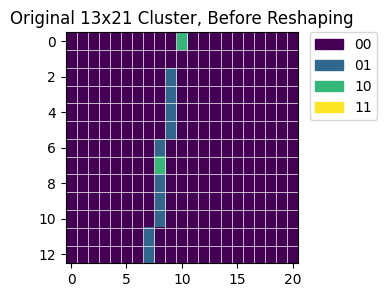

(21,)
Reshaping: Overflow in cluster 0 at 2000ps:
  Top overflow: [   0.    0.    0.    0.    0.    0.    0.    0.    0.    9. 2278.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.]
  Bottom overflow: [   0.    0.    0.    0.    0.    0.    0. 3114. 1416.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.]


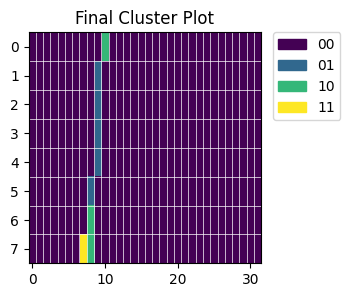

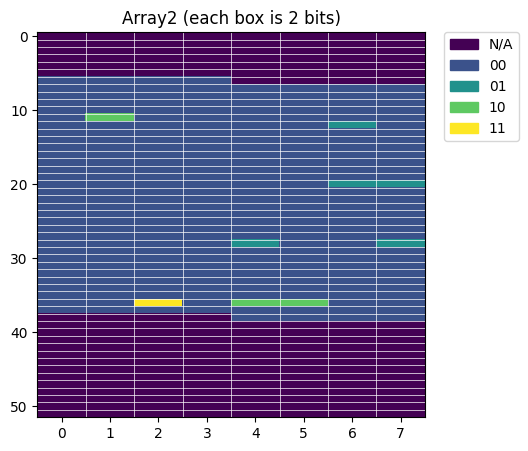

In [8]:
clusterSlice_ex = recon3d.iloc[0].to_numpy().reshape(20,13,21)[9]
time_label_ex = 200*9+200
#final_in_ex = reshape_pixelav(clusterSlice_ex, 0, time_label_ex)
bitstring_ex = make_bit_string(clusterSlice_ex, 0, time_label_ex)
array2_ex = make_array2(bitstring_ex, imageArray=True, zoomImage=True)

In [7]:
bit_string = bitstring_ex
len(bit_string)

512

In [29]:
print(len_w2_f2)

1672


[104, 3]
[104, 2]
[104, 1]
[104, 0]
[105, 7]
[105, 6]
[105, 5]
[105, 4]
[105, 3]
[105, 2]
[105, 1]
[105, 0]
[106, 7]
[106, 6]
[106, 5]
[106, 4]
[106, 3]
[106, 2]
[106, 1]
[106, 0]
[107, 7]
[107, 6]
[107, 5]
[107, 4]
[107, 3]
[107, 2]
[107, 1]
[107, 0]
[108, 7]
[108, 6]
[108, 5]
[108, 4]
[108, 3]
[108, 2]
[108, 1]
[108, 0]
[109, 7]
[109, 6]
[109, 5]
[109, 4]
[109, 3]
[109, 2]
[109, 1]
[109, 0]
[110, 7]
[110, 6]
[110, 5]
[110, 4]
[110, 3]
[110, 2]
[110, 1]
[110, 0]
[111, 7]
[111, 6]
[111, 5]
[111, 4]
[111, 3]
[111, 2]
[111, 1]
[111, 0]
[112, 7]
[112, 6]
[112, 5]
[112, 4]
[112, 3]
[112, 2]
[112, 1]
[112, 0]
[113, 7]
[113, 6]
[113, 5]
[113, 4]
[113, 3]
[113, 2]
[113, 1]
[113, 0]
[114, 7]
[114, 6]
[114, 5]
[114, 4]
[114, 3]
[114, 2]
[114, 1]
[114, 0]
[115, 7]
[115, 6]
[115, 5]
[115, 4]
[115, 3]
[115, 2]
[115, 1]
[115, 0]
[116, 7]
[116, 6]
[116, 5]
[116, 4]
[116, 3]
[116, 2]
[116, 1]
[116, 0]
[117, 7]
[117, 6]
[117, 5]
[117, 4]
[117, 3]
[117, 2]
[117, 1]
[117, 0]
[118, 7]
[118, 6]
[118, 5]
[

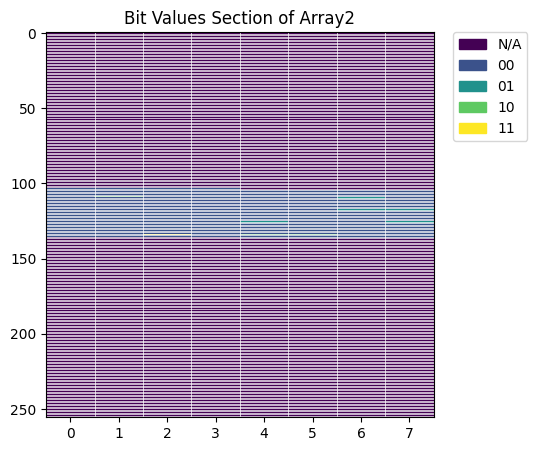

In [50]:
ar2row = 256
ar2col = 16
array2 = np.zeros((ar2row,ar2col))
len_w2_f2 = (104*16)+8
len_bits = (8*32)*2
labels = []

# fake numbers for shift register and dnn parts of the array
w2_f2 = [0]*len_w2_f2
unused = [0]*((256*16)-len_w2_f2-len_bits)

i=0
for row in range(ar2row):
    for col in reversed(range(ar2col)):
        if i < len_w2_f2: 
            array2[row,col] = w2_f2[i]
        elif len_w2_f2 <= i < len_w2_f2 + len_bits: #filling array with individual bits
            array2[row, col] = int(bit_string[i-len_w2_f2])
        elif i >= len_w2_f2+len_bits:
            array2[row, col] = unused[i - (len_w2_f2+len(bit_string))]
        i += 1


heatmap = np.zeros((ar2row, ar2col//2))
bit_i = 0
ii = 0
for row in range(ar2row):
    for col in reversed(range(ar2col//2)):
        if ii < len_w2_f2//2:
            heatmap[row, col] = 0
        elif len_w2_f2//2 <= ii <len_w2_f2//2 + len_bits//2: 
            if bit_i < len_bits: 
                label = bit_string[bit_i:bit_i+2]
                labels.append(label)
                if label == "00":
                    colorval = 1
                elif label == "01":
                    colorval = 2
                elif label == "10":
                    colorval = 3
                elif label == "11":
                    colorval = 4
                heatmap[row, col] = colorval
                bit_i += 2
        elif ii>=len_w2_f2//2 + len_bits//2:
            heatmap[row, col]=0 
        ii += 1

fig, ax = plt.subplots(figsize=(5, 5))
cmap = plt.get_cmap('viridis', 5) 
norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, 5.5, 1), ncolors=cmap.N)
legend_labels = ['N/A', '00', '01', '10', '11']
colors = [cmap(norm(i)) for i in range(5)]
cax = ax.imshow(heatmap, cmap=cmap, interpolation='none', aspect='auto', vmin=0, vmax=4)
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(5)]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
ax.set_xticks(np.arange(-0.5,heatmap.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5,heatmap.shape[0], 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', size=0)

ax.set_title('Bit Values Section of Array2')
plt.show()

In [46]:
len(labels)

256

**Scan chain to Shift Register conversion:**  
The Shift Register data is a series of 2-bit representations per pixel that starts in the top right corner of the array (figure 5) and goes RT-RB-LT-LB. Meanwhile, the Scan Chain takes 3 bits per pixel (will add this transition soon), starts with the right side of the array (pixel 63), and goes in a LB-RB-RT-LT order. This code will translate between those two formats so that we can tell which spot in the array is coming from which pixel. 
 

In [ ]:
test_string = [0]*512
test_string[0], test_string[-1] = 1, 1
test_string = ''.join(map(str, test_string))

def shiftreg_to_scanchain(bit_string):
    big_row_len = 16*2*2*2
    row_len = int(big_row_len/2)
    big_row_start = 0
    scanchain_map = []
    while big_row_start < big_row_len*4:
        section_row0 = bit_string[big_row_start:(big_row_start + row_len)][::-1]
        section_row1 = bit_string[big_row_start+row_len:big_row_start+row_len*2][::-1]

        move_right = 0
        while move_right < 64:
            idx = 0 + move_right
            lb = section_row1[idx] + section_row1[idx+1]
            rb = section_row1[idx+2] + section_row1[idx+3]
            rt = section_row0[idx+2] + section_row0[idx+3]
            lt = section_row0[idx] + section_row0[idx+1]

            square = lb + rb + rt + lt
            scanchain_map.append(square)
            move_right += 4
        big_row_start += big_row_len
    scanchain_map = ''.join(scanchain_map)
    
    # assuming thresholds are the same as in the 2-bit version 
    scanchain_map_final = []
    for i in range(0, len(scanchain_map), 2):
        pixel = scanchain_map[i]+scanchain_map[i+1]
        if pixel == '00':
            newpixel = '000'
        elif pixel == '01':
            newpixel = '001'
        elif pixel == '10':
            newpixel = '011'
        else:
            newpixel = '111'
        scanchain_map_final.append(newpixel)
    return(''.join(scanchain_map_final))